# Exploratory Data Analysis on the UWO dataset
WV.DSIOT

Done by KPP (pern) in 2024!

## Setup notebook

In [1]:
# enable autoreload when modules are changed externally
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import json

from bokeh.io import output_notebook, show 
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, DatetimeTickFormatter, RangeTool, HoverTool
from bokeh.layouts import column
from bokeh.palettes import Category20
output_notebook()   # enables Bokeh in Jupyter notebook

import src.data.UWOtools as uwot

Loading BokehJS ...

## Global definitions

In [10]:

StartDate = None
EndDate = None

# specify how many data points should be used for the evaluation; use None for all data points
NrDataPoints = None # 10000 / None

# set data range for the plotting the flow rates
flow_rate_range = (0.0, 200.0)

# Get the directory that contains the current file
current_dir = os.getcwd()

Note the flow_rate_range that was added for plotting; try plotting without setting a range, then you know why it was added.

## Get all flow sensor data

### List all sites that measure flow rate

In [1]:
# this thakes a while (>17s), so store the result in a file and reload it; delete the file if you want to recompute
file_name = os.path.join(current_dir, 'temp', 'flow_rate_sites.csv')
if os.path.exists(file_name):
    flow_rate_sites = pd.read_csv(file_name)
    print('loaded flow rate sites from file')
else:
    flow_rate_sites = uwot.GetSitesWithVariable('flow_rate')

    # store in file
    flow_rate_sites.to_csv(file_name, header=True, index=False)

# print(flow_rate_sites)

NameError: name 'os' is not defined

### Build list with flow sensors to evaluate

In [5]:
# get all sensor names of flow sensors and exclude the overflow sensors
# this thakes a while (3:40 min), so store the result in a file and reload it; delete the file if you want to recompute

# HINT: start w/o the overflow flow sensors and include them later to see that the range check is important

file_name = os.path.join(current_dir, 'temp', 'flow_rate_sensor_names.csv')
if os.path.exists(file_name):
    with open(file_name, 'r') as f:
        flow_rate_sensor_names = json.load(f)
    print('loaded flow_rate_sensor_names sites from file')
else:
    # init list of sensors and time series data
    flow_rate_sensor_names = []

    # iterate through all sites
    for ii, site_row in flow_rate_sites.iterrows():

        # # list all sensors installed in the site
        # print(f"Installed sensors in site {site_row['name']}:")
        # sensors = uwot.GetSensorsForSite(site_row['name'])
        # for index, row in sensors.iterrows():
        #     print(f"   {row['name']}:   {row['description']}")
        
        # iterate through all sensors
        sensors = uwot.GetSensorsForSite(site_row['name'])
        for ii, sensor_row in sensors.iterrows():
            # check if it is a flow sensor
            #if sensor_row['name'].startswith('bf_') and not sensor_row['name'].endswith('_overflow'):
            if sensor_row['name'].startswith('bf_'):
                # add to sensor list
                flow_rate_sensor_names.append(sensor_row['name'])
                print(f"Adding sensor '{sensor_row['name']}':   {sensor_row['description']}")
    
    # store in file
    with open(file_name, 'w') as f:
        json.dump(flow_rate_sensor_names, f)

# # print the sensor names neatly underneath each other
# print("\n".join(flow_rate_sensor_names))


loaded flow_rate_sensor_names sites from file


### Get all sensor data

#### Version 1: limit number of data points

We limit the number of data points to 100 to show the desired effect. If the number is increased to 10'000, I experience an out of memory error for the selected time period; the resulting data frame would be 29 GiB in size!!
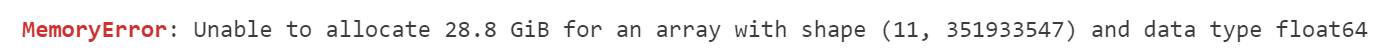

In [ ]:
NrDataPoints2 = 100

# init data frame
flow_rate_data = pd.DataFrame()

for sensor_name in flow_rate_sensor_names:

    # get time series
    ts = uwot.GetTimeSeries(source_name=sensor_name, start_date=StartDate, end_date=EndDate) #, limit=NrDataPoints2)
    print(f"{sensor_name:<35}: {ts.shape[0]} entries found", end="\n")

    # name the column after the sensor and use timestamp as index
    ts.rename(columns={'value': sensor_name}, inplace=True)
    ts.set_index('timestamp', inplace=True)

    # merge to data frame
    # Note: timestamp is an index, not a column, so flow_rate_data['timestamp'] will not work. Use flow_rate_data.index or first_valid_index() instead
    flow_rate_data = pd.merge(flow_rate_data, ts, how='outer', left_index=True, right_index=True)

# print length of data frame
print(f"   data frame length: {flow_rate_data.shape[0]}", end="\n")
ts.head()

bf_f07_23_bahnhofstr               : 122022 entries found
bf_plsRKPI1102_rubpw80sbw_overflow : 73440 entries found
bf_plsRKBU1101_rub128basin_usterstr: 73440 entries found
bf_plsRKBU1102_rub128basin_overflow: 73440 entries found
bf_plsRKBA1101_rubbasin_ara_overflow: 73440 entries found
bf_plsRKBM1101_3r_rub_morg_overflow: 73440 entries found
bf_plsZUL1100_inflow_ara           : 73440 entries found
bf_f08_166_luppmenweg              : 117496 entries found
bf_f10_22a_bahnhofstr              : 0 entries found
bf_f02_555_mesikerstr              : 145068 entries found
bf_f03_11e_russikerstr             : 150920 entries found


For only 100 samples per sensor and 13 sensors, the df has >6 Mio rows. This can happen because of the (outer) join explosion, when the time stamps used to merge the data frames together are slightly different, because for each unique time stamp, a new row is introduced. Expand the next cell to get a bit more context.

<small>The phenomenon you're experiencing is commonly referred to as a "join explosion" or specifically in your case, an "outer join explosion." This occurs when a join operation (especially an outer join) between two datasets results in a significantly larger number of rows than in the original datasets. This typically happens due to:

1. **Mismatched or Non-Unique Join Keys**: When the keys used for joining are not unique or have slight variations that are still considered distinct (like your time stamps), leading to multiple rows from one dataset being matched with multiple rows from the other dataset.

2. **Cartesian Product for Non-Matching Keys**: In the context of an outer join, for each non-matching key in both datasets, new rows are created with `NaN` values to fill in for missing data on one side of the join. This ensures no data is lost but can massively increase the number of rows if there are many such non-matching keys.

The term "explosion" aptly describes the rapid increase in the number of rows, which can lead to significant performance issues and unexpected results, as you've noticed.

**Opinion**: To mitigate join explosion, careful preprocessing of the datasets to ensure that join keys are as aligned as possible can be very helpful. This might include cleaning the data to standardize the time stamps, removing duplicates, or even aggregating data points at a higher time resolution to reduce the granularity and the chances of slight mismatches. Additionally, considering the specific requirements of your analysis, you might opt for different types of joins or a more manual merging process that allows for greater control over how duplicates and near-duplicates are handled.</small>

#### Version 2: drop duplicates

In [ ]:
NrDataPoints2 = 10000

# init data frame
flow_rate_data = pd.DataFrame()

for sensor_name in flow_rate_sensor_names:

    # get time series
    ts = uwot.GetTimeSeries(source_name=sensor_name, start_date=StartDate, end_date=EndDate) #, limit=NrDataPoints2)
    print(f"{sensor_name:<36}: {ts.shape[0]} entries found", end="")

    # remove duplicate timestamps
    duplicates = ts.duplicated(subset=['timestamp']).sum()
    if duplicates > 0:
        ts.drop_duplicates(subset=['timestamp'], keep="first", inplace=True) # note that this implies keep='first'
    print(f" / {duplicates} duplicates / {len(ts)} remaining", end="\n")

    # test alignment: delete first 50 entries 
    # if True and sensor_name == 'bf_plsRKBU1101_rub128basin_usterstr':
    #     ts = ts.iloc[50:]
    #     print(f" / deleted first 100 entries", end="")

    # name the column after the sensor and use timestamp as index
    ts.rename(columns={'value': sensor_name}, inplace=True)
    ts.set_index('timestamp', inplace=True)

    # merge to data frame
    # Note: timestamp is an index, not a column, so flow_rate_data['timestamp'] will not work. Use flow_rate_data.index or first_valid_index() instead
    flow_rate_data = pd.merge(flow_rate_data, ts, how='outer', left_index=True, right_index=True)

# print length of data frame
print(f"   data frame length: {flow_rate_data.shape[0]}", end="\n")

Notes:
1. Inspecting the output tells us, that there are empty time series (at least for certain time periodes), so don't add empty columns next time.
1. To test the merge, the first 50 entries are deleted on purpose and by manual inspection of the resulting data frame, it was confirmed, that the merge works indeed based on time stamp.
1. We also see, that some sensors contain many duplicate entries. What do we do with this information?
1. It's always wise to print some info about the steps you are taking, i.e. print the number of dropped entries.

#### Version 3: With resampling to 2.5 min (and drop duplicates)

In [6]:
# resampling rate for the evaluation
resampling_rate = "2.5min"

# interpolation limit: gaps in the time series that are longer than this limit will not be interpolated
interpolation_limit = 4 # interpolate will fill up to X consecutive NaN values

In [11]:
# init data frame
flow_rate_data = pd.DataFrame()

# print a reminder that we should not forget about the drop duplicate issue!
print("Keeping the first duplicate entry for each time stamp")

for sensor_name in flow_rate_sensor_names:

    # get time series
    ts = uwot.GetTimeSeries(source_name=sensor_name, start_date=StartDate, end_date=EndDate, limit=NrDataPoints)
    print(f"{sensor_name:<35}: {ts.shape[0]} entries found", end="")

    # remove duplicate timestamps
    duplicates = ts.duplicated(subset=['timestamp']).sum()
    if duplicates > 0:
        ###### NOTE: Would need to drop all duplicates (keep=False), but for testing, I keep the first occurence (keep='first')
        ts.drop_duplicates(subset=['timestamp'], inplace=True, keep='first')
    print(f" / {duplicates} duplicates / {len(ts)} remaining", end="")

    # don't add empty time series
    if ts.shape[0] == 0:
        print(f" / empty time series, skipping")
        continue

    # name the column after the sensor and use timestamp as index
    ts.rename(columns={'value': sensor_name}, inplace=True)
    ts.set_index('timestamp', inplace=True)

    # resample to specified time interval
    original_freq = ts.index.to_series().diff().dropna().median()
    std_dev = ts.index.to_series().diff().std()
    print(f" / freq(stddev)={original_freq.total_seconds()/60 if not pd.isna(original_freq) else 'NaT'}({std_dev.total_seconds()/60 if not pd.isna(original_freq) else 'NaT'}) min") # type: ignore
    
    # Convert to Timedelta for comparison
    desired_freq = pd.to_timedelta(resampling_rate)

    if original_freq > desired_freq: # type: ignore
        # Upsampling
        ts_resampled = ts.resample(resampling_rate).interpolate(method='time', limit=interpolation_limit)
    else:
        # Downsampling (example using mean for aggregation)
        ts_resampled = ts.resample(resampling_rate).mean()

    # merge to data frame
    # Note: timestamp is an index, not a column, so flow_rate_data['timestamp'] will not work. Use flow_rate_data.index or first_valid_index() instead
    flow_rate_data = pd.merge(flow_rate_data, ts_resampled, how='outer', left_index=True, right_index=True)

Keeping the first duplicate entry for each time stamp
bf_f07_23_bahnhofstr               : 2753370 entries found / 2447440 duplicates / 305930 remaining / freq(stddev)=5.0(40.02801005) min
bf_plsRKPI1102_rubpw80sbw_overflow : 1578240 entries found / 0 duplicates / 1578240 remaining / freq(stddev)=1.0(0.0) min
bf_plsRKBU1101_rub128basin_usterstr: 1578240 entries found / 0 duplicates / 1578240 remaining / freq(stddev)=1.0(0.0) min
bf_plsRKBU1102_rub128basin_overflow: 1578240 entries found / 0 duplicates / 1578240 remaining / freq(stddev)=1.0(0.0) min
bf_plsRKBA1101_rubbasin_ara_overflow: 1578240 entries found / 0 duplicates / 1578240 remaining / freq(stddev)=1.0(0.0) min
bf_plsRKBM1101_3r_rub_morg_overflow: 1578240 entries found / 0 duplicates / 1578240 remaining / freq(stddev)=1.0(0.0) min
bf_plsZUL1100_inflow_ara           : 1578240 entries found / 0 duplicates / 1578240 remaining / freq(stddev)=1.0(0.0) min
bf_f08_166_luppmenweg              : 2329296 entries found / 2038134 duplicate

In [14]:
flow_rate_data.to_feather(path="./temp/flow_rate_data")

Notes:
1. We skipped adding the empty time series

### Plot sensor data

In [1]:
# === create figure Flow Rates
p = figure(title="Flow Rates", 
           x_axis_type="datetime", x_range=(flow_rate_data.first_valid_index(), flow_rate_data.last_valid_index()),
           y_axis_label='Flow rate [l/s]', y_range=flow_rate_range,
           sizing_mode="stretch_width", height=350,
           tools="pan,wheel_zoom,box_zoom,reset,zoom_in,zoom_out,yzoom_in,yzoom_out") 

# format the x-axis tick labels as datetime strings
p.xaxis.formatter = DatetimeTickFormatter(hours="%y%m%d %H", days="%Y %m %d", months="%Y %m", years="%Y")


# === create figure for range tool
p_range = figure(title="Drag the middle and edges of the selection box to change the range above",
                x_axis_type="datetime", x_range=(flow_rate_data.first_valid_index(), flow_rate_data.last_valid_index()),#p.x_range,
                y_axis_type=None, y_range=flow_rate_range,
                sizing_mode="stretch_width", height=150,
                tools="")
p_range.xaxis.formatter = p.xaxis.formatter;

range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

p_range.ygrid.grid_line_color = None
p_range.add_tools(range_tool)


# === hover tool
hover = HoverTool()
hover.tooltips = [("Sensore name", "$name")]
p.add_tools(hover)


# Plot all sensor readings
colors = Category20[len(Category20)]
source = ColumnDataSource(data=flow_rate_data.reset_index())
for i, col in enumerate(flow_rate_data.columns):
    p.line(x='timestamp', y=col, source=source,
           line_color=colors[i % len(colors)], line_width=1,
           name=col, legend_label=col)

    p_range.line(x='timestamp', y=col, source=source,
           line_color=colors[i % len(colors)], line_width=1,
           name=col)

# set legend attributes
p.legend.orientation = "vertical"
p.legend.location = "top_left"
p.legend.click_policy="hide"
p.legend.label_text_font_size = "8pt"

# move the legend outside the plot area
p.add_layout(p.legend[0], 'left')

# show the results
l = column(p, p_range) # type: ignore
l.sizing_mode = "stretch_width" # type: ignore
show(l)

NameError: name 'figure' is not defined

Notes:
- Look at the overflow sensors. How do we treat them?